In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nb_005 import *

# Faces

## Setup

Download the dataset [here](https://download.pytorch.org/tutorial/faces.zip) from the pytoch tutorial on transforms. Unzip it in the data directory, so that data/faces/ contains the images and the csv file.

In [3]:
PATH = Path('data/faces/')

In [4]:
img_fns = get_image_files(PATH)
img_fns = [fn for fn in img_fns if str(fn)[-3:] == 'jpg']
len(img_fns)

69

In [5]:
import pandas as pd
poses = pd.read_csv(PATH/'face_landmarks.csv')

Reading the coordinates. We adopt pytorch convention in grid_sampler where the coordinates are normalized between -1 and 1. (-1,-1) is the top left corner, (1,1) the bottom right. 

In [6]:
pose_pnts = []
for i, fname in enumerate(img_fns):
    w,h = Image.open(fname).size
    coords = np.array(poses[poses['image_name'] == fname.name].iloc[0][1:], dtype=np.float32)
    coords = torch.tensor(coords).view(-1,2)
    coords.div_(torch.tensor([w/2,h/2])[None]).add_(-1)
    pose_pnts.append(coords)

In [7]:
len(pose_pnts)

69

Let's have a look at the data.

In [8]:
def show_pose(img, pnts, ax=None):
    if ax is None: _,ax = plt.subplots()
    ax.imshow(img)
    w,h = img.size
    pnts = (pnts.numpy() + 1) * np.array([w/2,h/2])[None]
    ax.scatter(pnts[:, 0], pnts[:, 1], s=10, marker='.', c='r')

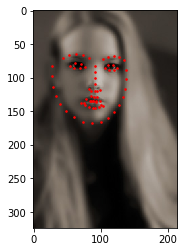

In [9]:
img = Image.open(img_fns[0])
show_pose(img, pose_pnts[0])

In [10]:
@dataclass
class CoordTargetDataset(Dataset):
    x_fns:List[Path]; coords:List[List[float]]
    def __post_init__(self): assert len(self.x_fns)==len(self.coords)
    def __repr__(self): return f'{type(self).__name__} of len {len(self.x_fns)}'
    def __len__(self): return len(self.x_fns)
    def __getitem__(self, i): return open_image(self.x_fns[i]), self.coords[i]

In [11]:
img_ds = CoordTargetDataset(img_fns, pose_pnts)

## Transforms

Affine, coords, crop transform first.

In [12]:
def pad_coords(c, padding_mode):
    if padding_mode=='zeros' or padding_mode=='border':
        mask = (c[:,0] >=-1) * (c[:,0] <=1) * (c[:,1] >=-1) * (c[:,1] <=1)
        return c[mask]
    elif padding_mode=='reflect':
        c[c < -1] = -2 - c[c < -1]
        c[c > 1] = 2  - c[c > 1]
    return c

In [13]:
def affine_inv_mult(c,m):
    size = c.size()
    c = c.view(-1,2)
    a = torch.inverse(m[:2,:2].t()) 
    c = torch.addmm(-torch.mv(a,m[:2,2]), c, a) 
    return c.view(size)

In [14]:
#export
def get_resize_target(img_sz, crop_target, do_crop=False):
    if crop_target is None: return None
    ch,r,c = img_sz
    target_r,target_c = crop_target
    ratio = (min if do_crop else max)(r/target_r, c/target_c)
    return ch,round(r/ratio),round(c/ratio)

In [135]:
def _apply_affine(img, size=None, padding_mode='reflect', do_crop=False, aspect=None, mult=32,
                  mats=None, func=None, crop_func=None, is_coord=False, **kwargs):
    if size is not None and not is_listy(size):
        size = listify(size,2) if aspect is None else get_crop_target(size, aspect, mult)
    if (not mats) and func is None and size is None: return img
    im_size = torch.Size((1,int(img[0][0]),int(img[0][1]))) if is_coord else img.size()
    resize_target = get_resize_target(im_size, size, do_crop=do_crop)
    c = img[1:] if is_coord else affine_grid(img, torch.eye(3), size=resize_target)
    if func is not None: c = func(c, im_size, invert=is_coord)
    if mats:
        m = affines_mat(mats)
        c = affine_mult(c, img.new_tensor(m)) if not is_coord else affine_inv_mult(c, img.new_tensor(m))
    if is_coord: 
        res = pad_coords(c, padding_mode=padding_mode)
        if resize_target is None: resize_target = im_size
        res = torch.cat([torch.Tensor([resize_target[1],resize_target[2]]).float()[None], res],0)
    else: 
        res = grid_sample(img, c, padding_mode=padding_mode, **kwargs)
        if padding_mode=='zeros': padding_mode='constant'
    if crop_func is not None: res = crop_func(res, size=size, padding_mode=padding_mode, is_coord=is_coord)
    return res

def apply_affine(mats=None, func=None, crop_func=None):
    return partial(_apply_affine, mats=mats, func=func, crop_func=crop_func)

nb_003a.apply_affine = apply_affine

In [125]:
TfmY = IntEnum('TfmY', 'No Pixel Mask Coord BBox')

class TfmDataset(Dataset):
    def __init__(self, ds:Dataset, tfms:Collection[Callable]=None, tfm_y:TfmY=TfmY.No, **kwargs):
        self.ds,self.tfms,self.tfm_y,self.kwargs = ds,tfms,tfm_y,kwargs

    def __len__(self): return len(self.ds)

    def __getitem__(self,idx):
        x,y = self.ds[idx]
        if self.tfms is not None:
            tfm = apply_tfms(self.tfms)
            if self.tfm_y == TfmY.Coord: 
                y = torch.cat([torch.Tensor([x.size(1),x.size(2)]).float()[None], y],0)
            x = tfm(x, **self.kwargs)
            if self.tfm_y != TfmY.No and y is not None:
                coord,seg = (self.tfm_y == TfmY.Coord),(self.tfm_y == TfmY.Mask)
                y = tfm(y, segmentation=seg, is_coord=coord, **self.kwargs)[1:]
        return x,y

In [90]:
tfms = [rotate_tfm(degrees=(-30,30))]

In [91]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros')

In [92]:
def show_pose(img, pnts, ax=None):
    if ax is None: _,ax = plt.subplots()
    ax.imshow(img.numpy().transpose(1,2,0))
    w,h = img.size(2),img.size(1)
    if len(pnts) != 0:
        pnts = (pnts.numpy() + 1) * np.array([w/2,h/2])[None]
        ax.scatter(pnts[:, 0], pnts[:, 1], s=10, marker='.', c='r')

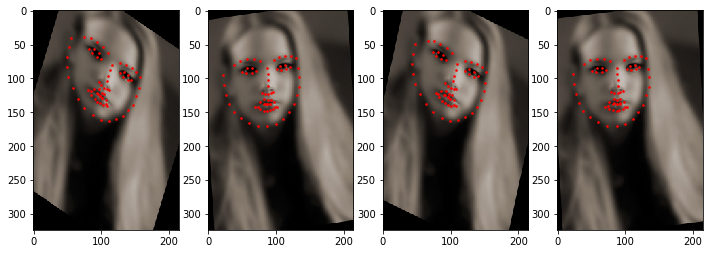

In [93]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

In [55]:
tfms = [zoom_tfm(scale=(1,2),row_pct=(0,1),col_pct=(0,1))]

In [56]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros', size=100, do_crop=True)

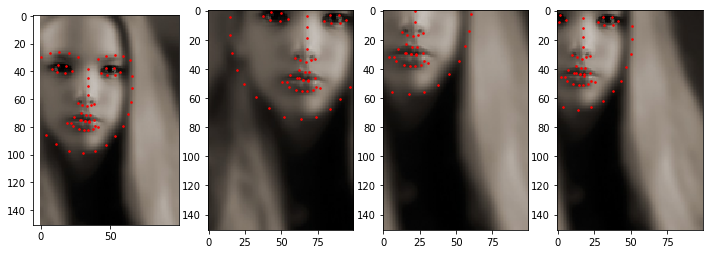

In [60]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

In [24]:
apply_tfms

<function nb_003a.apply_tfms(tfms)>

In [48]:
import pdb

In [58]:
def _apply_tfm_func(pixel_func,lighting_func,affine_func,start_func, x, segmentation=False, is_coord=False, **kwargs):
    if not np.any([pixel_func,lighting_func,affine_func,start_func]): return x
    x = x.clone()
    if start_func is not None:  x = start_func(x, is_coord=is_coord)
    if affine_func is not None: x = affine_func(x, is_coord=is_coord, **kwargs)
    if lighting_func is not None and not segmentation and not is_coord: x = lighting_func(x)
    if pixel_func is not None: x = pixel_func(x, is_coord=is_coord)
    return x

def apply_tfms(tfms):
    resolve_tfms(tfms)
    grouped_tfms = dict_groupby(listify(tfms), lambda o: o.tfm_type)
    start_tfms,affine_tfms,coord_tfms,pixel_tfms,lighting_tfms,crop_tfms = [
        (grouped_tfms.get(o)) for o in TfmType]
    lighting_func = apply_lighting(compose(lighting_tfms))
    mats = [o() for o in listify(affine_tfms)]
    affine_func = apply_affine(mats, func=compose(coord_tfms), crop_func=compose(crop_tfms))
    return partial(_apply_tfm_func,
        compose(pixel_tfms),lighting_func,affine_func,compose(start_tfms))

nb_003a.apply_tfms = apply_tfms

In [112]:
@reg_transform
def pad(x, padding, mode='reflect', is_coord=False) -> TfmType.Start:
    if is_coord:
        pad = torch.Tensor([x[0][1]/(x[0][1] + 2*padding), x[0][0]/(x[0][0] + 2*padding)])
        x[1:] = x[1:].mul_(pad[None])
        x[0] += 2*padding
        return x
    else: return F.pad(x[None], (padding,)*4, mode=mode)[0]

In [113]:
tfms = [pad_tfm(padding=100)]

In [114]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord)

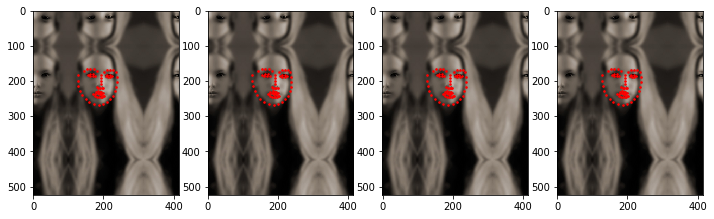

In [115]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

In [103]:
def crop_coords(c, row, col, rows, cols):
    h,w = int(c[0][0]),int(c[0][1])
    c = c[1:]
    c.mul_(torch.Tensor([w/cols,h/rows])[None])
    c.add_(-1 + torch.Tensor([w/cols-2*col/cols,h/rows-2*row/rows])[None])
    c = pad_coords(c, padding_mode='zeros')
    return torch.cat([torch.Tensor([rows,cols]).float()[None], c],0)

In [105]:
@reg_transform
def crop(x, size, is_coord=False, row_pct:uniform=0.5, col_pct:uniform=0.5) -> TfmType.Pixel:
    size = listify(size,2)
    rows,cols = size
    img_size = torch.Size((1,int(x[0][0]),int(x[0][1]))) if is_coord else x.size()
    row = int((img_size[1]-rows+1) * row_pct)
    col = int((img_size[2]-cols+1) * col_pct)
    if is_coord: return crop_coords(x,row,col,rows,cols)
    return x[:, row:row+rows, col:col+cols].contiguous()

In [109]:
tfms = [crop_tfm(size=200,row_pct=(0,1),col_pct=(0,1))]

In [110]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord)

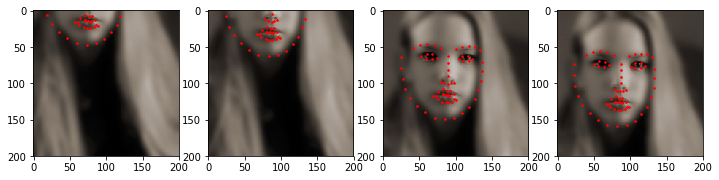

In [111]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

In [117]:
@reg_transform
def crop_pad(x, size, padding_mode='reflect', is_coord=False,
             row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Crop:
    size = listify(size,2)
    rows,cols = size
    img_size = torch.Size((1,int(x[0][0]),int(x[0][1]))) if is_coord else x.size()
    if img_size[1]<rows or img_size[2]<cols:
        row_pad = max((rows-img_size[1]+1)//2, 0)
        col_pad = max((cols-img_size[2]+1)//2, 0)
        new_size = torch.Size(img_size[0], img_size[1] + 2*row_pad, img_size[2] + 2*col_pad) 
        if is_coord: 
            pad = torch.Tensor([img_size[1]/new_size[1], img_size[2]/new_size[2]])
            x[1:] = x[1:].mul_(pad[None])
            x[0] += torch.Tensor([2*row_pad,2*col_pad])
        else: x = F.pad(x[None], (col_pad,col_pad,row_pad,row_pad), mode=padding_mode)[0]
        img_size = new_size
    
    row = int((img_size[1]-rows+1)*row_pct)
    col = int((img_size[2]-cols+1)*col_pct)
    if is_coord: return crop_coords(x,row,col,rows,cols)
    x = x[:, row:row+rows, col:col+cols]
    return x.contiguous() # without this, get NaN later - don't know why

In [118]:
tfms = [crop_pad_tfm(row_pct=(0,1),col_pct=(0,1))]

In [119]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros', do_crop=True, size=100)

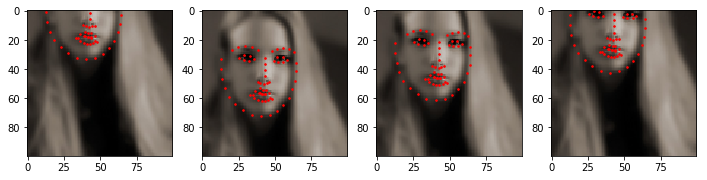

In [120]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

In [136]:
@reg_transform
def tilt(c, img_size, invert=False, direction:rand_int=0, magnitude:uniform=0) -> TfmType.Coord:
    orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]
    if direction == 0:   targ_pts = [[-1,-1], [-1,1], [1,-1-magnitude], [1,1+magnitude]]
    elif direction == 1: targ_pts = [[-1,-1-magnitude], [-1,1+magnitude], [1,-1], [1,1]]
    elif direction == 2: targ_pts = [[-1,-1], [-1-magnitude,1], [1,-1], [1+magnitude,1]]
    elif direction == 3: targ_pts = [[-1-magnitude,-1], [-1,1], [1+magnitude,-1], [1,1]]  
    coeffs = find_coeffs(targ_pts, orig_pts) if invert else find_coeffs(orig_pts, targ_pts)
    return apply_perspective(c, coeffs)

In [137]:
tfms = [tilt_tfm(direction=(0,3), magnitude=(-0.4,0.4))]

In [138]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros', do_crop=True, size=100)

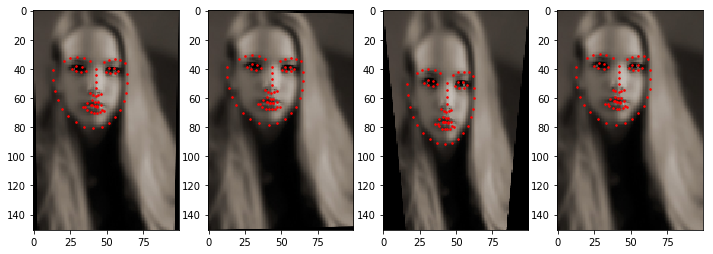

In [139]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

In [140]:
@reg_transform
def flip_lr(x, is_coord=False) -> TfmType.Pixel: 
    if is_coord:
        x[1:,0] = -x[1:,0]
        return x
    else: return x.flip(2)

In [141]:
tfms = [flip_lr_tfm(p=0.5)]

In [142]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros', do_crop=True, size=100)

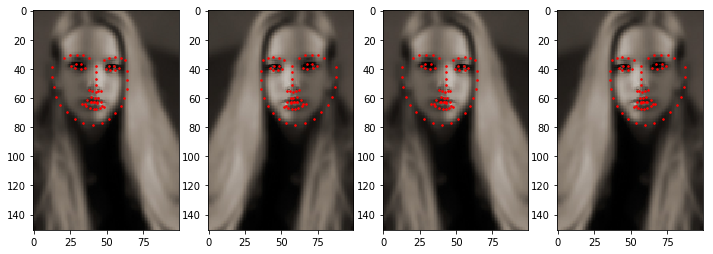

In [143]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)